### Library Imports

In [276]:
import pandas as pd
from pprint import pprint
import warnings
import matplotlib.pyplot as plt
import numpy as np 

from sklearn.externals import joblib
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import SGDClassifier
from sklearn.multiclass import OneVsRestClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn import svm
from sklearn.metrics import (roc_auc_score, confusion_matrix,
                             accuracy_score, roc_curve,
                             precision_recall_curve, f1_score)
from sklearn import metrics

from scipy.sparse import hstack
import xml.etree.ElementTree as ET

import nltk
from nltk.corpus import stopwords
from string import punctuation

### Load train and test datasets

In [69]:
train_data = 'data/Laptops_Train_v2.xml'
test_data = 'data/Laptops_Test_Gold.xml'

### XML Parser to Dataframe

In [128]:
pd.set_option('display.max_colwidth', -1)

class Xml2DataFrame:
    
    @staticmethod
    def parse_root(root):
        """Return pandas dataframe from given xml data"""
        data_list = []
        xml_data = dict()

        target_words = []
        for child in root:
            xml_data['id'] = child.attrib.get('id')
            text = child.find('text').text.lower()
            xml_data['text'] = text
            for aspectTerms in child.iter('aspectTerms'):
                aspectInfos = []
                polarityInfos = []
                for asp_term in aspectTerms:
                    aspectInfos.append(asp_term.attrib)
                    # print(asp_term.attrib)
                xml_data['aspect_info'] = aspectInfos
            data_list.append(xml_data)
            xml_data = {}

        return data_list

    def process_data(self, path):
        root = ET.parse(path).getroot()
        
        """ Initiate the root XML, parse it, and return a dataframe"""
        structure_data = self.parse_root(root)
        df = pd.DataFrame([[k.get('id'), k.get('text'), k.get('aspect_info')] for k in iter(structure_data)],
                          columns=['id', 'text', 'aspect_info'])
        return df

### Part of Speech tag (noun, adjective, verb, adverb) using stanford pos tagger

In [208]:
class POSTagger:

    @staticmethod
    def pos_tagger(text):
        text = nltk.word_tokenize(text)
        stopwords_en = stopwords.words('english')
        stopwords_en_withpunct = set(stopwords_en).union(set(punctuation))
        text = [word for word in text if word not in stopwords_en_withpunct]
        tagged_pos_list = nltk.pos_tag(text)
        return tagged_pos_list

    def filter_pos_tag(self, tagged_text):
        final_text_list = []
        matching_tag = ['NN','NNS','NNP','NNPS','RB','RBR','RBS','JJ','JJR','JJS','VB','VBD','VBG','VBN','VBP','VBZ']

        for word, tag in tagged_text:
            final_text = []
            if tag in matching_tag:
                final_text.append(word)
                final_text_list.append((' '.join(final_text)))
        return self.combine(final_text_list)

    @staticmethod
    def combine(filtered_tags):
        filtered_string = ' '.join(filtered_tags)
        return filtered_string

In [104]:
# xml parser
def get_xml_data(path):
    xml2df = Xml2DataFrame()
    xml_dataframe = xml2df.process_data(path)
    return xml_dataframe

### Preprocessing

In [209]:
# Making list to train
train_dataframe = get_xml_data(train_data)
train_text_list = train_dataframe['text']
train_aspects_list = list(train_dataframe['aspect_info'])
print(train_text_list.head())

0    i charge it at night and skip taking the cord with me because of the good battery life.                                                                                            
1    i bought a hp pavilion dv4-1222nr laptop and have had so many problems with the computer.                                                                                          
2    the tech guy then said the service center does not do 1-to-1 exchange and i have to direct my concern to the "sales" team, which is the retail shop which i bought my netbook from.
3    i investigated netbooks and saw the toshiba nb305-n410bl.                                                                                                                          
4    the other day i had a presentation to do for a seminar at a large conference in town- lots of people, little time to prep and have to set up a computer to a projector, etc.       
Name: text, dtype: object


In [87]:
# POSTag function wrapper
def pos_tag(review):
    tagged_text_list = []
    pos_tagger = POSTagger()
    for text in review:
        tagged_text_list.append(pos_tagger.pos_tagger(text=text))
    return tagged_text_list


# POSTag filtering of noun,adjective,verb,adverb
def filter_tag(tagged_reviews):
    filtered_list = []
    pos_tagger = POSTagger()
    for tagged_review in tagged_reviews:
        filtered_list.append(pos_tagger.filter_pos_tag(tagged_review))
    return filtered_list

In [89]:
# tag POS
tagged_text_list_train = pos_tag(train_text_list)
joblib.dump(tagged_text_list_train, 'tagged_text_list_train.pkl')
tagged_text_list_train = joblib.load('tagged_text_list_train.pkl')

In [132]:
# train list after filtering
final_train_text_list = filter_tag(tagged_text_list_train)

print(final_train_text_list[:5])

['charge night skip taking cord good battery life', 'bought hp pavilion dv4-1222nr laptop many problems computer', 'tech guy said service center 1-to-1 exchange direct concern sales team retail shop bought netbook', 'investigated netbooks saw toshiba nb305-n410bl', 'day presentation seminar large conference town- lots people little time prep set computer projector etc']


### Feature Selection - Selecting most common aspects

In [171]:
#Selecting only 50 most common aspect.
def get_most_common_aspect(aspect_list):
    import nltk
    aspect_terms = []

    aspect_list = list(aspect_list.aspect_info)

    for inner_list in aspect_list:
        if inner_list is not None:
            for _dict in inner_list:
                # for key in _dict:
                aspect_terms.append(_dict.get('term'))

    most_common_aspect = [k for k, v in nltk.FreqDist(aspect_terms).most_common(50)]
    return most_common_aspect

In [172]:
# generate data frame
def get_data_frame(text_list, train_aspects_list, most_common_aspect):
    data = {'Text': text_list}
    df = pd.DataFrame(data)
    for inner_list in train_aspects_list:
        if inner_list is not None:
            for _dict in inner_list:
                # for key in _dict:
                if _dict.get('term') in most_common_aspect:
                    df.loc[train_aspects_list.index(inner_list), _dict.get('term')] = _dict.get('polarity')
    return df

In [173]:
# generate data frame for aspect extraction task
def get_aspect_data_frame(df, most_common_aspect):
    for common_aspect in most_common_aspect:
        df[common_aspect] = df[common_aspect].replace(['positive','negative','neutral','conflict'],[1,1,1,1])
    df = df.fillna(0)
    return df

In [174]:
most_common_aspect = get_most_common_aspect(train_dataframe)
pprint(most_common_aspect)

['screen',
 'price',
 'use',
 'battery life',
 'battery',
 'keyboard',
 'programs',
 'software',
 'features',
 'warranty',
 'hard drive',
 'quality',
 'size',
 'performance',
 'speed',
 'Windows',
 'memory',
 'graphics',
 'applications',
 'motherboard',
 'runs',
 'Vista',
 'gaming',
 'system',
 'program',
 'works',
 'charge',
 'design',
 'display',
 'power supply',
 'Windows 7',
 'service',
 'operating system',
 'windows',
 'warrenty',
 'value',
 'keys',
 'mouse',
 'OS',
 'speakers',
 'extended warranty',
 'shipping',
 'games',
 'cost',
 'work',
 'processor',
 'look',
 'hardware',
 'power',
 'weight']


In [175]:
#get data frame
df_train = get_data_frame(final_train_text_list,train_aspects_list, most_common_aspect)
df_train.head()

,Text,battery life,quality,applications,use,features,screen,battery,gaming,speed,...,graphics,power,OS,programs,size,design,Windows,weight,speakers,charge
0,charge night skip taking cord good battery life,positive,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,bought hp pavilion dv4-1222nr laptop many problems computer,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,tech guy said service center 1-to-1 exchange direct concern sales team retail shop bought netbook,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,investigated netbooks saw toshiba nb305-n410bl,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,day presentation seminar large conference town- lots people little time prep set computer projector etc,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [176]:
# get expect term df
df_train_aspect = get_aspect_data_frame(df_train, most_common_aspect)
df_train_aspect.head()

,Text,battery life,quality,applications,use,features,screen,battery,gaming,speed,...,graphics,power,OS,programs,size,design,Windows,weight,speakers,charge
0,charge night skip taking cord good battery life,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,bought hp pavilion dv4-1222nr laptop many problems computer,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,tech guy said service center 1-to-1 exchange direct concern sales team retail shop bought netbook,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,investigated netbooks saw toshiba nb305-n410bl,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,day presentation seminar large conference town- lots people little time prep set computer projector etc,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [177]:
df_train_aspect = df_train_aspect.reindex(sorted(df_train_aspect.columns), axis=1)
df_train_aspect.head()

,OS,Text,Vista,Windows,Windows 7,applications,battery,battery life,charge,cost,...,speed,system,use,value,warranty,warrenty,weight,windows,work,works
0,0.0,charge night skip taking cord good battery life,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,bought hp pavilion dv4-1222nr laptop many problems computer,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,tech guy said service center 1-to-1 exchange direct concern sales team retail shop bought netbook,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,investigated netbooks saw toshiba nb305-n410bl,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,day presentation seminar large conference town- lots people little time prep set computer projector etc,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [178]:
# Similar for test list
test_dataframe = get_xml_data(test_data)
test_text_list = train_dataframe['text']
test_aspects_list = list(train_dataframe['aspect_info'])

In [179]:
tagged_text_list_test = pos_tag(test_text_list)
joblib.dump(tagged_text_list_test, 'tagged_text_list_test.pkl')
tagged_text_list_test=joblib.load('tagged_text_list_test.pkl')

In [180]:
final_test_text_list = filter_tag(tagged_text_list_test)

In [181]:
df_test = get_data_frame(final_test_text_list,test_aspects_list, most_common_aspect)
df_test_aspect = get_aspect_data_frame(df_test, most_common_aspect)
df_test_aspect = df_test_aspect.reindex(sorted(df_test_aspect.columns), axis=1)

In [268]:
# Sort the data frame according to aspect's name and separate data(X) and target(y)
X_train= df_train_aspect.Text
y_train = df_train_aspect.drop('Text', 1)
print(y_train[:5])

X_test = df_test_aspect.Text
y_test = df_test_aspect.drop('Text', 1)
final_most_common_aspect = list(y_train)
final_most_common_aspect

    OS  Vista  Windows  Windows 7  applications  battery  battery life  \
0  0.0  0.0    0.0      0.0        0.0           0.0      1.0            
1  0.0  0.0    0.0      0.0        0.0           0.0      0.0            
2  0.0  0.0    0.0      0.0        0.0           0.0      0.0            
3  0.0  0.0    0.0      0.0        0.0           0.0      0.0            
4  0.0  0.0    0.0      0.0        0.0           0.0      0.0            

   charge  cost  design  ...    speed  system  use  value  warranty  warrenty  \
0  0.0     0.0   0.0     ...    0.0    0.0     0.0  0.0    0.0       0.0        
1  0.0     0.0   0.0     ...    0.0    0.0     0.0  0.0    0.0       0.0        
2  0.0     0.0   0.0     ...    0.0    0.0     0.0  0.0    0.0       0.0        
3  0.0     0.0   0.0     ...    0.0    0.0     0.0  0.0    0.0       0.0        
4  0.0     0.0   0.0     ...    0.0    0.0     0.0  0.0    0.0       0.0        

   weight  windows  work  works  
0  0.0     0.0      0.0   0.0    


['OS',
 'Vista',
 'Windows',
 'Windows 7',
 'applications',
 'battery',
 'battery life',
 'charge',
 'cost',
 'design',
 'display',
 'extended warranty',
 'features',
 'games',
 'gaming',
 'graphics',
 'hard drive',
 'hardware',
 'keyboard',
 'keys',
 'look',
 'memory',
 'motherboard',
 'mouse',
 'operating system',
 'performance',
 'power',
 'power supply',
 'price',
 'processor',
 'program',
 'programs',
 'quality',
 'runs',
 'screen',
 'service',
 'shipping',
 'size',
 'software',
 'speakers',
 'speed',
 'system',
 'use',
 'value',
 'warranty',
 'warrenty',
 'weight',
 'windows',
 'work',
 'works']

In [269]:
# Change y_train to numpy array
import numpy as np
y_train = np.asarray(y_train, dtype=np.int64)
y_test = np.asarray(y_test, dtype=np.int64)
print(y_train[:5])

[[0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0]]


### Modeling - Naive Bayes classifier for multinomial models(MultinomialNB), Support Vector Classification (SVC), Linear Support Vector Classification (LinearSVC), Linear classifiers (SVM, logistic regression, a.o.) with stochastic gradient descent learning (SGDClassifier)

In [270]:
# Generate word vectors using CountVectorizer to be applied on models
from sklearn.feature_extraction.text import CountVectorizer
vect = CountVectorizer(max_df=1.0, stop_words='english')  
X_train_dtm = vect.fit_transform(X_train)
X_test_dtm = vect.transform(X_test)

In [271]:
# Create various models. These are multi-label models.
nb_classif = OneVsRestClassifier(MultinomialNB()).fit(X_train_dtm, y_train)
C = 1.0 
# SVregularization parameter
svc = OneVsRestClassifier(svm.SVC(kernel='linear', C=C)).fit(X_train_dtm, y_train)
lin_svc = OneVsRestClassifier(svm.LinearSVC(C=C)).fit(X_train_dtm, y_train)
sgd = OneVsRestClassifier(SGDClassifier(max_iter=1000)).fit(X_train_dtm,y_train)

In [272]:
# Predict the test data using classifiers
y_pred_class = nb_classif.predict(X_test_dtm)
y_pred_class_svc = svc.predict(X_test_dtm)
y_pred_class_lin_svc = lin_svc.predict(X_test_dtm)
y_pred_class_sgd = sgd.predict(X_test_dtm)

### Evaluation Metrics - Test metrics of all aspect extraction classifiers

In [188]:
print(metrics.accuracy_score(y_test,y_pred_class))
print(metrics.accuracy_score(y_test,y_pred_class_svc))
print(metrics.accuracy_score(y_test,y_pred_class_lin_svc))
print(metrics.accuracy_score(y_test,y_pred_class_sgd))

0.819704433497537
0.9967159277504105
0.9970443349753695
0.9973727422003285


In [189]:
print(metrics.precision_score(y_test,y_pred_class,average='micro'))
print(metrics.precision_score(y_test,y_pred_class_svc,average='micro'))
print(metrics.precision_score(y_test,y_pred_class_lin_svc,average='micro'))
print(metrics.precision_score(y_test,y_pred_class_sgd,average='micro'))

0.8848920863309353
0.9921171171171171
0.9921259842519685
0.9932432432432432


In [190]:
print(metrics.recall_score(y_test,y_pred_class,average='micro'))
print(metrics.recall_score(y_test,y_pred_class_svc,average='micro'))
print(metrics.recall_score(y_test,y_pred_class_lin_svc,average='micro'))
print(metrics.recall_score(y_test,y_pred_class_sgd,average='micro'))

0.27765237020316025
0.9943566591422122
0.9954853273137697
0.9954853273137697


In [191]:
print(metrics.f1_score(y_test,y_pred_class,average='micro'))
print(metrics.f1_score(y_test,y_pred_class_svc,average='micro'))
print(metrics.f1_score(y_test,y_pred_class_lin_svc,average='micro'))
print(metrics.f1_score(y_test,y_pred_class_sgd,average='micro'))

0.422680412371134
0.9932356257046222
0.9938028169014084
0.9943630214205187


In [290]:
def show_values(pc, fmt="%.2f", **kw):    
    pc.update_scalarmappable()
    ax = pc.axes
    for p, color, value in zip(pc.get_paths(), pc.get_facecolors(), pc.get_array()):
        x, y = p.vertices[:-2, :].mean(0)
        if np.all(color[:3] > 0.5):
            color = (0.0, 0.0, 0.0)
        else:
            color = (1.0, 1.0, 1.0)
        ax.text(x, y, fmt % value, ha="center", va="center", color=color, **kw)


def cm2inch(*tupl):
    inch = 2.54
    if type(tupl[0]) == tuple:
        return tuple(i/inch for i in tupl[0])
    else:
        return tuple(i/inch for i in tupl)


def heatmap(AUC, title, xlabel, ylabel, xticklabels, yticklabels, figure_width=40, figure_height=20, 
            correct_orientation=False, cmap='RdBu'):
    # Plot it out
    fig, ax = plt.subplots()    
    #c = ax.pcolor(AUC, edgecolors='k', linestyle= 'dashed', linewidths=0.2, cmap='RdBu', vmin=0.0, vmax=1.0)
    c = ax.pcolor(AUC, edgecolors='k', linestyle= 'dashed', linewidths=0.2, cmap=cmap)

    # put the major ticks at the middle of each cell
    ax.set_yticks(np.arange(AUC.shape[0]) + 0.5, minor=False)
    ax.set_xticks(np.arange(AUC.shape[1]) + 0.5, minor=False)

    # set tick labels
    #ax.set_xticklabels(np.arange(1,AUC.shape[1]+1), minor=False)
    ax.set_xticklabels(xticklabels, minor=False)
    ax.set_yticklabels(yticklabels, minor=False)

    # set title and x/y labels
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)      

    # Remove last blank column
    plt.xlim( (0, AUC.shape[1]) )

    # Turn off all the ticks
    ax = plt.gca()    
    for t in ax.xaxis.get_major_ticks():
        t.tick1On = False
        t.tick2On = False
    for t in ax.yaxis.get_major_ticks():
        t.tick1On = False
        t.tick2On = False

    # Add color bar
    plt.colorbar(c)

    # Add text in each cell 
    show_values(c)

    # Proper orientation (origin at the top left instead of bottom left)
    if correct_orientation:
        ax.invert_yaxis()
        ax.xaxis.tick_top()       

    # resize 
    fig = plt.gcf()
    #fig.set_size_inches(cm2inch(40, 20))
    #fig.set_size_inches(cm2inch(40*4, 20*4))
    fig.set_size_inches(cm2inch(figure_width, figure_height))



def plot_classification_report(classification_report, title, cmap='RdBu'):
    lines = classification_report.split('\n')

    classes = []
    plotMat = []
    support = []
    class_names = []
    for line in lines[2 : (len(lines) - 2)]:
        t = line.strip().split()
        if len(t) < 2: continue
        classes.append(t[0])
        v = [float(x) for x in t[1: len(t) - 1]]
        support.append(int(t[-1]))
        class_names.append(t[0])
        #print(v)
        plotMat.append(v)

    #print('plotMat: {0}'.format(plotMat))
    #print('support: {0}'.format(support))

    xlabel = 'Metrics'
    ylabel = 'Aspects'
    xticklabels = ['Precision', 'Recall', 'F1-score']
    yticklabels = ['{0} ({1})'.format(class_names[idx], sup) for idx, sup  in enumerate(support)]
    figure_width = 25
    figure_height = len(class_names) + 7
    correct_orientation = False
    heatmap(np.array(plotMat), title, xlabel, ylabel, xticklabels, yticklabels, figure_width, figure_height, 
            correct_orientation, cmap=cmap)

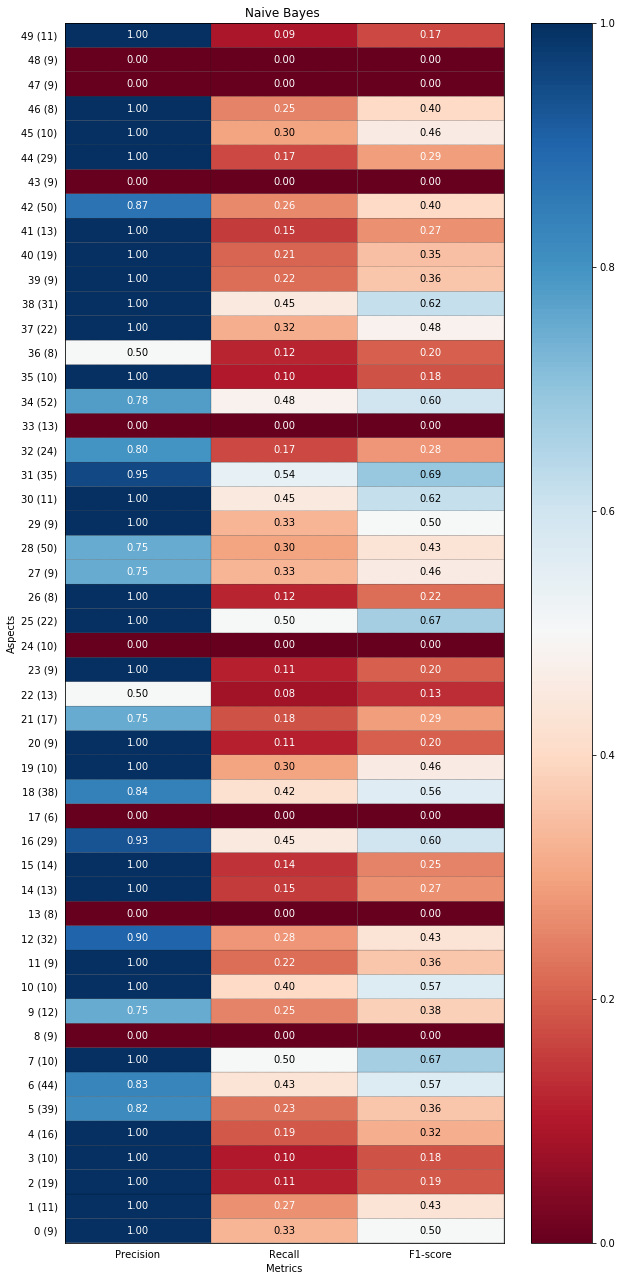

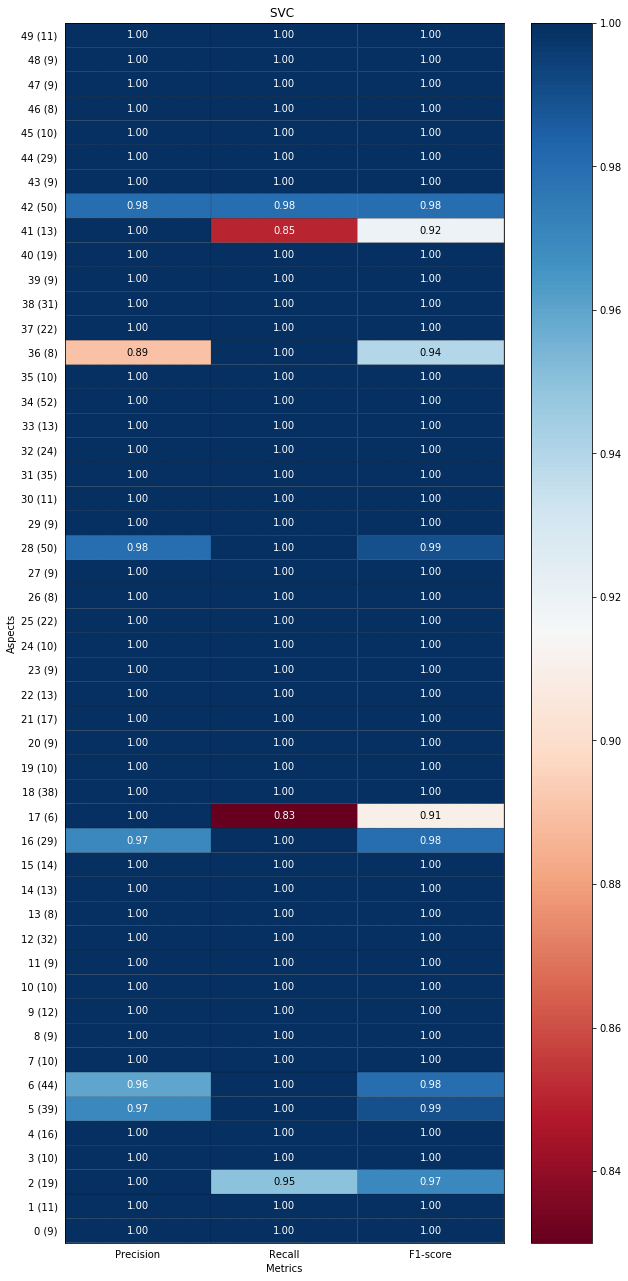

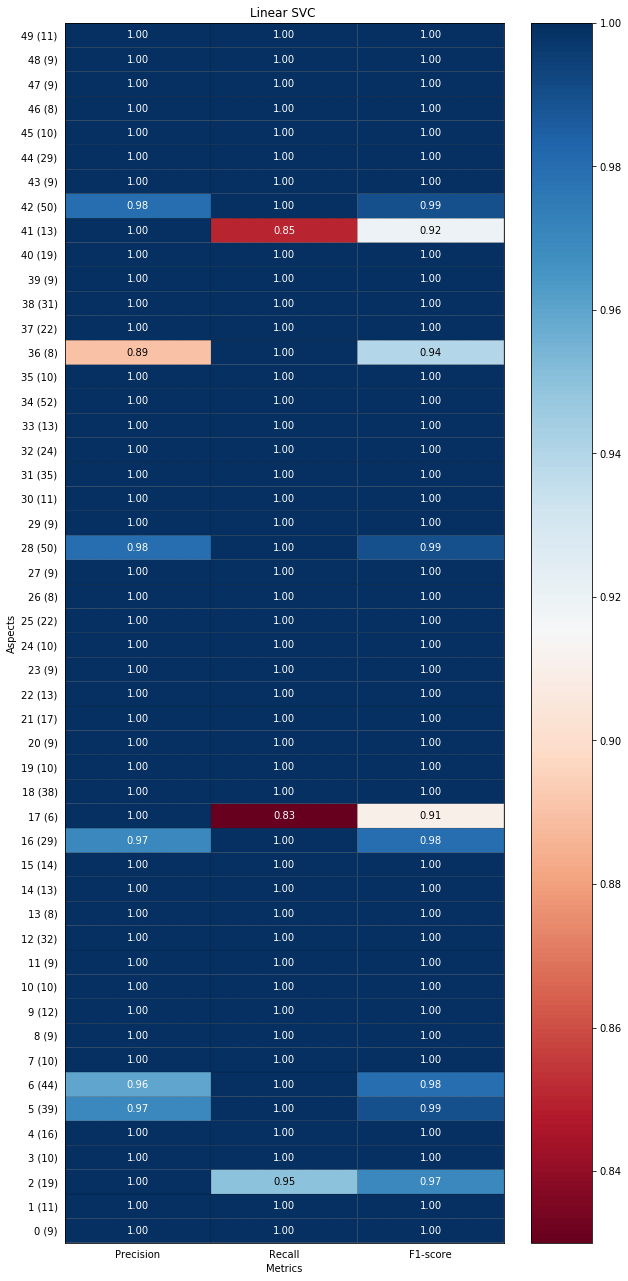

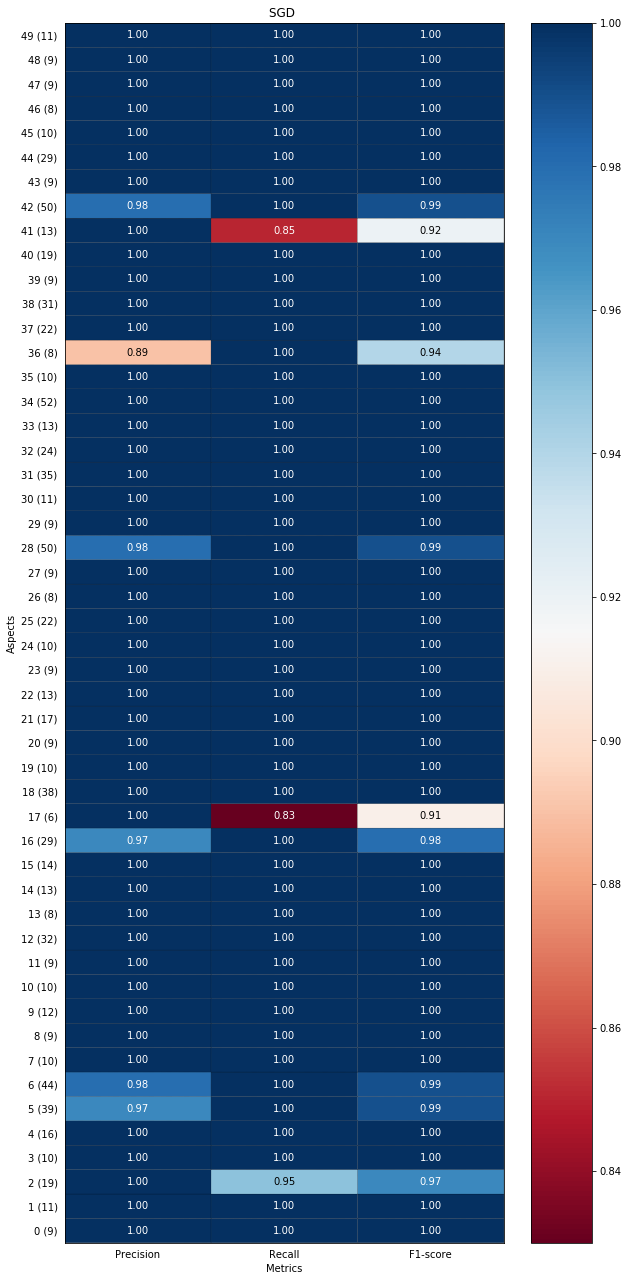

In [291]:
# Classification Report
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    plot_classification_report(metrics.classification_report(y_test, y_pred_class), "Naive Bayes ")
    plot_classification_report(metrics.classification_report(y_test, y_pred_class_svc), "SVC ")
    plot_classification_report(metrics.classification_report(y_test, y_pred_class_lin_svc), "Linear SVC ")
    plot_classification_report(metrics.classification_report(y_test, y_pred_class_sgd), "SGD ")

In [266]:
def plot_conf_matrix(conf_mat, title):
    # Define figure size and figure ratios
    plt.figure(figsize=(16, 8))
    plt.matshow(conf_mat, cmap=plt.cm.Reds, alpha=0.2)
    for i in range(2):
        for j in range(2):
            plt.text(x=j, y=i, s=conf_mat[i, j], ha="center", va="center")
    plt.title("Confusion Matrix: " + title, y=1.1, fontdict={"fontsize": 20})
    plt.xlabel("Predicted", fontdict={"fontsize": 14})
    plt.ylabel("Actual", fontdict={"fontsize": 14});

<Figure size 1152x576 with 0 Axes>

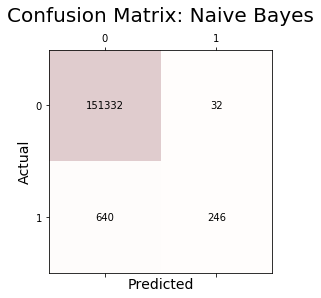

<Figure size 1152x576 with 0 Axes>

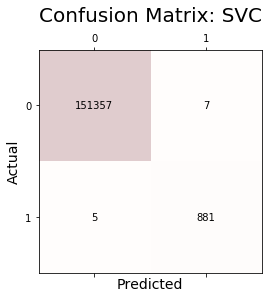

<Figure size 1152x576 with 0 Axes>

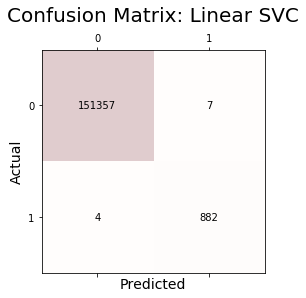

<Figure size 1152x576 with 0 Axes>

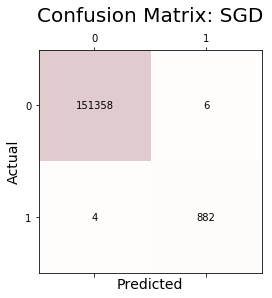

In [267]:
# Naive Bayes
plot_conf_matrix(confusion_matrix(y_test.flatten(), y_pred_class.flatten()), "Naive Bayes")
# SVC
plot_conf_matrix(confusion_matrix(y_test.flatten(), y_pred_class_svc.flatten()), "SVC")
# Linear SVC
plot_conf_matrix(confusion_matrix(y_test.flatten(), y_pred_class_lin_svc.flatten()), "Linear SVC")
# SGD
plot_conf_matrix(confusion_matrix(y_test.flatten(), y_pred_class_sgd.flatten()), "SGD")

### Converting to BIO Format as per requirement

In [219]:
# convert into bio format
class BIO:

    def convert_into_bio(self, text, predicted_aspect_terms_list, common_words_list):
        text_list = text.split()
        # print(text_list)
        df = pd.DataFrame({'text': text_list, 'BIO': 'O'})

        bio_dict = self.bio_mapper(common_words_list=common_words_list, prediction=predicted_aspect_terms_list)
        bio_filtered_dict = self.filter_predicted_words(bio_dict)

        for item in bio_filtered_dict:
            final_list = self.matcher(text, item)
            if final_list[1] - final_list[0] == 0:
                df.at[final_list[0], 'BIO'] = 'B'
            else:
                df.at[final_list[0], 'BIO'] = 'B'
                for index in range(final_list[0] + 1, final_list[1] + 1):
                        df.at[index, 'BIO'] = 'I'

        return df

    def bio_mapper(self, common_words_list, prediction):
        bio_dict = dict()

        for i in range(len(common_words_list)):
            bio_dict[common_words_list[i]] = prediction[i]

        return bio_dict

    def matcher(self, text, word):
        split_word = word.split()
        split_text = text.split(word)

        if len(split_text) > 1:
            start = len(split_text[0].split())
            end = start + len(split_word) - 1
        return start, end

    def filter_predicted_words(self, _dict):

        final_list = []

        for key, value in _dict.items():
            if value == 1:
                final_list.append(key)

        return final_list;

In [220]:
def get_dict_aspect(y,most_common_aspect):
    position=[]
    for innerlist in y:
        position.append([i for i, j in enumerate(innerlist) if j == 1])
    sorted_common=sorted(most_common_aspect)
    dict_aspect=[]
    for innerlist in position:
        inner_dict={}
        for word in sorted_common:
            if sorted_common.index(word) in innerlist:
                inner_dict[word]= 5
            else:
                inner_dict[word]=0
        dict_aspect.append(inner_dict)
    return dict_aspect

In [221]:
# Generating extra feature that indicates which aspect category is present in the review
train_dict_aspect=get_dict_aspect(y_train, most_common_aspect)
d_train=DictVectorizer() 
X_train_aspect_dtm = d_train.fit_transform(train_dict_aspect)

# y_test is used to generated extra feature in order to test the performance of 2nd classifer.
#Use y_pred_class_svc(Highest performer for aspect classification) as input for extra feature to test the overall performace.
test_dict_aspect=get_dict_aspect(y_test, most_common_aspect)
d_test=DictVectorizer()

In [222]:
def BIO_format(text, predicted_output, common_words):
    bio_obj = BIO()
    df = bio_obj.convert_into_bio(text, predicted_output, common_words_list=common_words)
    return df

In [223]:
# Aspect term extractor of user's input.
user_input = "The battery life is really good and its size is reasonable"

# Preprocessing and vectorizing
tagged_user_input = pos_tag([user_input])
print(tagged_user_input)
filter_tagged_user_input = filter_tag(tagged_user_input)
print(filter_tagged_user_input)

user_input_series = pd.Series(filter_tagged_user_input)
print(user_input_series)
user_input_series_dtm = vect.transform(user_input_series)
print(user_input_series_dtm)
# print(user_input_series[:5])

predict_aspect= sgd.predict(user_input_series_dtm)
print(predict_aspect)
# predict_aspect_data = predict_aspect[0]
extra_feature=get_dict_aspect(predict_aspect, most_common_aspect)
extra_feature_dtm=DictVectorizer().fit_transform(extra_feature)
predict_aspect

[[('The', 'DT'), ('battery', 'NN'), ('life', 'NN'), ('really', 'RB'), ('good', 'JJ'), ('size', 'NN'), ('reasonable', 'JJ')]]
['battery life really good size reasonable']
0    battery life really good size reasonable
dtype: object
  (0, 259)	1
  (0, 1339)	1
  (0, 1810)	1
  (0, 2573)	1
  (0, 2577)	1
  (0, 2944)	1
[[0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 1 0 0 0 0 0 0 0 0 0 0 0 0]]


array([[0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0]])

In [218]:
df = BIO_format(user_input, predict_aspect[0], final_most_common_aspect)
df

,text,BIO
0,The,O
1,battery,B
2,life,I
3,is,O
4,really,O
5,good,O
6,and,O
7,its,O
8,size,B
9,is,O
